In [13]:
import scipy.io as sio    # import scipy.io for .mat file I/O
import scipy
from scipy import stats  
import numpy as np                         # import numpy
import matplotlib.pyplot as plt            # import matplotlib.pyplot for figure plotting
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.autograd as autograd
from torch.nn import Linear
import torch.nn.functional as F
from torch.autograd import Function
from torch_geometric.utils import dropout_edge, to_dense_adj
from torch import linalg as LA
from torch_geometric.nn import knn_graph, Sequential
from torch_geometric.nn.conv import MessagePassing, GATConv, GatedGraphConv, SAGEConv, GraphConv
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, LeakyReLU, Sigmoid, BatchNorm1d as BN, Conv1d, Dropout, Tanh, Softmax
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.transforms import ToUndirected

from utils import *

In [14]:
# # create directory for storing input data
import os
input_data_path = './data/input/COLOR/instances'
if not os.path.exists(input_data_path):
    os.makedirs(input_data_path)

In [15]:
# Known chromatic numbers for specified problems (from references)
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [33]:
from torch_geometric import datasets

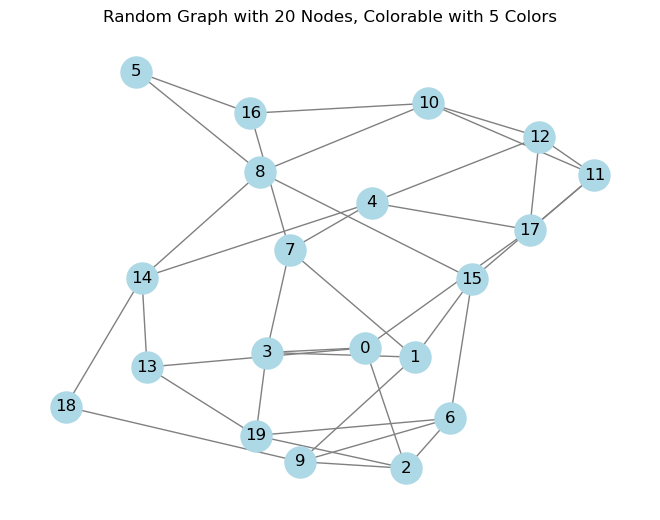

Chromatic Number: 4


In [36]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_colorable_graph(num_nodes, max_degree):
    """
    Generates a random graph with a specified number of nodes
    and ensures it is colorable with max_degree + 1 colors.
    
    Args:
        num_nodes (int): Number of nodes in the graph.
        max_degree (int): Maximum degree for any node.
        
    Returns:
        G (networkx.Graph): A random graph.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    
    for node in range(num_nodes):
        # Randomly connect to other nodes while ensuring max_degree
        possible_neighbors = [n for n in range(num_nodes) if n != node and not G.has_edge(node, n)]
        random.shuffle(possible_neighbors)
        num_edges = min(max_degree - G.degree[node], len(possible_neighbors))
        for neighbor in possible_neighbors[:num_edges]:
            if G.degree[neighbor] < max_degree:
                G.add_edge(node, neighbor)
    
    return G

# Generate the graph
num_nodes = 20
max_degree = 4  # Ensures 5-colorable graph
graph = generate_colorable_graph(num_nodes, max_degree)

# Visualize the graph
pos = nx.spring_layout(graph, seed=42)  # Layout for visualization
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.title(f"Random Graph with {num_nodes} Nodes, Colorable with 5 Colors")
plt.show()

# Check the chromatic number
colors = nx.coloring.greedy_color(graph, strategy="largest_first")
print(f"Chromatic Number: {max(colors.values()) + 1}")


In [ ]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'colo'

input_parent = './data/input/COLOR/instances'

# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)

# Load in graph
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

Building graph from contents of file: ./data/input/COLOR/instances\cora.cites


FileNotFoundError: [Errno 2] No such file or directory: './data/input/COLOR/instances\\cora.cites'

In [40]:
train_graph = from_networkx(graph)

In [41]:

train_graph.x = torch.ones(20,1)

tensor([4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 2, 2, 4, 2, 4, 2, 4],
       device='cuda:0')
Epoch 001, Train Loss: 14.8722, Val Loss: 14.8037, Val hard error: 29.0
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       device='cuda:0')
Epoch 002, Train Loss: 14.8036, Val Loss: 14.8149, Val hard error: 27.0
tensor([4, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 4, 4, 2, 2, 4, 2, 4, 2, 4],
       device='cuda:0')
Epoch 003, Train Loss: 14.8149, Val Loss: 14.8086, Val hard error: 27.0
tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0],
       device='cuda:0')
Epoch 004, Train Loss: 14.8086, Val Loss: 14.8054, Val hard error: 29.0
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
Epoch 005, Train Loss: 14.8054, Val Loss: 14.8072, Val hard error: 37.0
tensor([3, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 3, 3, 2, 3, 3, 2, 3, 2, 3],
       device='cuda:0')
Epoch 006, Train Loss: 14.8072, Val Loss: 14.8043, Val hard error: 9.0
tensor([1, 

Text(0.5, 0, 'epochs')

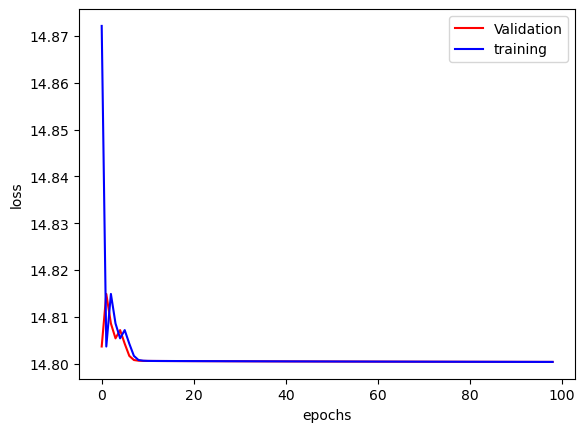

In [42]:
num_of_layers = 16
output_embedding_dim = 64
K = 5 #number of colors
torch_device = 'cuda'
model_type = 'GGNN'
save_name = 'first_run'
num_of_epochs = 100

train_loader = DataLoader([train_graph], batch_size=1, shuffle=True)
validation_loader = DataLoader([train_graph], batch_size=1, shuffle=False)

model = PICAN(output_embedding_dim, num_of_layers, K, model_type).to(torch_device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

plt.figure()
loss_, losst_, hard_ = trainmodel('model'+save_name, model, num_of_epochs, scheduler, train_loader,validation_loader, optimizer,torch_device,train_graph.num_nodes,K) #xyzg not BN()StraightThroughEstimator
print('min loss = ', np.min(np.array(loss_)))
print('At epoch ', np.argmin(np.array(loss_)))
print('max loss = ', np.max(np.array(loss_)))
print('Minimum wrong decision = ', np.min(np.array(hard_)))
print('At epoch = ', np.argmin(np.array(hard_)))
print(np.max(np.array(loss_)) - np.min(np.array(loss_)))
plt.plot(np.array(loss_), 'r', np.array(losst_), 'b')
plt.legend(('Validation','training'))
plt.ylabel('loss')
plt.xlabel('epochs')
#sio.savemat('train_loss_data/loss_performance'+save_name+'.mat',{'val_loss':loss_,'tr_loss':losst_,'hard loss':hard_})